In [2]:
import pandas as pd
# disable python warnings 
import warnings
warnings.filterwarnings('ignore')

In [3]:
# load data 
data  = pd.read_csv('../data/bundled_raw.csv')
pos_data = data[data['is_bundled'] == 1]
neg_data = data[data['is_bundled'] == 0]

In [4]:
data

,text,is_bundled
0,Emerson Community Experience,0
1,How could Emerson engage you in building a str...,0
2,"Discuss racism, anti-Semitism all forms of dis...",1
3,Regular communication,0
4,give staff time for this work,0
...,...,...
421,The people,0
422,The people,0
423,"The people, the passion, and the mission",0
424,It’s not very specific,0


In [1]:
#!pip install benepar
import benepar
#benepar.download('benepar_en3')

In [5]:
import benepar, spacy
nlp = spacy.load('en_core_web_lg')
if spacy.__version__.startswith('2'):
        nlp.add_pipe(benepar.BeneparComponent("benepar_en3"))
else:
        nlp.add_pipe("benepar", config={"model": "benepar_en3"})

# load embedding model 

from sentence_transformers import SentenceTransformer,util

model_name = 'all-mpnet-base-v2'

model = SentenceTransformer(model_name)

In [6]:
def parse_sentence(sentence):
    doc = nlp(sentence)
    return len(list(doc.sents))
logs = []
for text in pos_data.text.values:
    logs.append(parse_sentence(text))

# add to pos_data
pos_data['sentence_count'] = logs

# get freq 
import collections
freq = collections.Counter(logs)
print('pos texts : ')
print(freq)
logs = []
for text in neg_data.text.values:
    logs.append(parse_sentence(text))
# add to pos_data
neg_data['sentence_count'] = logs
freq = collections.Counter(logs)
print('neg texts : ')
print(freq)

pos texts : 
Counter({1: 43, 2: 10, 3: 5})
neg texts : 
Counter({1: 329, 2: 31, 3: 8})


In [23]:
condition = pos_data['sentence_count'] ==1
pos_data[condition]
text = pos_data[condition].sample(n=1).text.values[0]
print(text)

increasing the student loan and faculty salaries budgets and recruiting admissions/resumes from schools and communities with diverse student bodies


In [24]:
doc = nlp(text)
sent = list(doc.sents)[0]

print(sent._.parse_string)
print('----')
for child in sent._.children:
    print(child , child._.labels) 


(S (VP (VP (VBG increasing) (NP (DT the) (NML (NML (NN student) (NN loan)) (CC and) (NML (NN faculty) (NNS salaries))) (NNS budgets))) (CC and) (VP (VBG recruiting) (NP (NNS admissions) (SYM /) (NNS resumes)) (PP (IN from) (NP (NP (NNS schools) (CC and) (NNS communities)) (PP (IN with) (NP (JJ diverse) (NN student) (NNS bodies))))))))
----
increasing the student loan and faculty salaries budgets ('VP',)
and ()
recruiting admissions/resumes from schools and communities with diverse student bodies ('VP',)


In [166]:
class Span_extractor:

    def __init__(self, sentence: str,deep_extraction=True,debug=False, verify_treshold=0.7):
        self.sentence = sentence
        self.verify_treshold = verify_treshold
        self.debug=debug
        self.deep_extraction = deep_extraction
        self.doc = nlp(sentence)
        # loggers 
        self.spans_logger = []
    
    def is_valid_span(self, span):
        """check if span is valid

        Args:
            span (_type_): span to check

        Returns:
            _type_: True if valid, False otherwise
        """
        def RepresentsInt(s):
            try: 
                int(s)
                return True
            except ValueError:
                return False

        def is_propn(span):
            span_str = str(span)
            if len(span_str.split(' ')) == 1:
                token = [token for token in self.doc if token.text == span_str][0]
                print(token , token.pos_)
                try : 
                    
                    if token.pos_ in  ['PROPN','CCONJ']:
                        return True
                except:
                    pass
            return False
                
        if RepresentsInt(str(span)):
            return False
        if is_propn(span):
            return False
        
        
        
        
        return True
    
    def extract_spans(self,spacy_span):
        """extract NP,VP span from e sentence text

        Args:
            sentence (_type_): text (with 1 sentence)

        Returns:
            _type_: list of VP,NP spans
        """
        spans = []
        for child in spacy_span._.children:
            if self.debug : 
                print(child , list(child._.labels))
            intersection = set(child._.labels).intersection(set(['S','NP','VP','PP','ADJP','ADVP','NML']))
            if len(intersection)!=0:
                spans.append(child)
        # verify re-itteration
        span_len = []
        for span in spans:
            span_len.append(len(str(span).split(' ')))
        # normalise len
        span_len = [x/len(self.sentence.split(' ')) for x in span_len]
        spans_to_verify = [idx for idx, x in enumerate(span_len) if x > self.verify_treshold]
        return spans , spans_to_verify
    
    def itterate(self):
        """run the extractor

        Returns:
            _type_: list of VP,NP spans
        """
        sent = list(self.doc.sents)[0]
        spans,spans_to_verify = self.extract_spans(sent)
        if self.debug : 
            print('->',sent)
            pprint.pprint(spans)
            print(spans_to_verify)
            print('------')
        spans_to_log = [str(span) for idx ,span in enumerate(spans) if ( idx not in spans_to_verify)   and self.is_valid_span((span))]
        self.spans_logger.extend(spans_to_log)

        if self.deep_extraction :

            while spans_to_verify !=[] : 
                for span_id in spans_to_verify:
                    span = spans[span_id]
                    spans,spans_to_verify = self.extract_spans(span)
                    if self.debug : 
                        print('->',span)
                        pprint.pprint(spans)
                        print(spans_to_verify)
                        print('------')
                    spans_to_log = [str(span) for idx ,span in enumerate(spans) if ( idx not in spans_to_verify)   and self.is_valid_span((span))]
                    self.spans_logger.extend(spans_to_log)
    
    def get_spans(self):
        """get the extracted spans

        Returns:
            _type_: list of VP,NP spans
        """
        spans_logger_str = ' '.join(self.spans_logger)
        ratio = len(spans_logger_str.split(' ') )/len(self.sentence.split(' '))
        if ratio <0.3 :
            return ('PROBLEM' , self.sentence)
        return ('GOOD',self.spans_logger)
        
      
        
    


        






In [169]:
#text = 'Emerson has clearly made a real effort to address the student demands and other feedback around equity and inclusion, including the Teach-In on Race, expanding the number of positions that focus on access and belonging, etc.'
#text = 'Faculty and Staff Training in Disability advocacy; HR recognition of Mental Health needs; Anti-Racism training for Faculty/Staff'
condition = pos_data['sentence_count'] ==1
text = pos_data[condition].sample(n=1).text.values[0]
#text = 'hiring, retaining, promoting staff'
print(text)
extractor = Span_extractor(sentence= text ,deep_extraction=True,debug=False)
extractor.itterate()
meta, spans = extractor.get_spans()
meta,spans

Hiring and retaining staff of color; identifying and addressing barriers for participation in abroad/domestic programs;


('GOOD',
 ['Hiring and retaining staff of color',
  'identifying and addressing barriers for participation in abroad/domestic programs'])

In [132]:
# TODO 
# - encode spans 
# - plot umap 
# - use hiearchical clustering



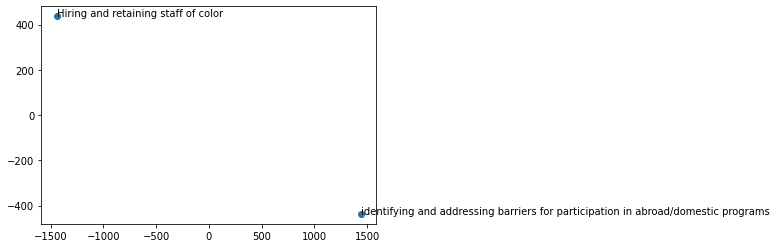

In [170]:
embeddings = model.encode(spans)
# umap 
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# reduce dim
embeddings = TSNE(n_components=2).fit_transform(embeddings)
# plot 
plt.scatter(embeddings[:,0],embeddings[:,1])
# add labels
for idx,span in enumerate(spans):
    plt.annotate(span,(embeddings[idx,0],embeddings[idx,1]))